## To-do
* The cavity mirror displacement x0 is not yet taken into account in Mirror
* The direction of deflection of the rays from mirror tilt does not depend on sign of the tilt. probably because I use the cos of the tilt somewhere that I should be using the sin.

In [1]:
from numpy import *
from matplotlib import pyplot as plt
from scipy.optimize import newton # the Newton-Raphson numerical solver
from simfuncs import *

## Ray tracing in a cavity

In [2]:
Mm = lambda th,mslope: array([[1,0],[0, (th+2*atan(1/mslope))/th]])
Md = lambda d: array([[1,d],[0,1]])

class Mirror:
        
    def __init__(self,RoC,r,z0,refl=1,tilt=0,x0=0):
        """
        Args:
            'RoC': surface radius of curvature. Positive if center of curvature to the "right"
            'r': the transverse radius, i.e. the clear aperture
            'z0': the location of the center of the surface along the optical axis z
            'refl': the reflection of the mirror. currently unused
            'tilt': the tilt of the mirror about an axis which bisects the surface profile and is
                perpendicular to the optical axis, in radians
            'x0': the position of the mirror wrt the x axis. x0=0 by default, so the mirror is on axis.
        """
        self.RoC = RoC
        self.r = r # radius
        self.refl = refl # not used yet
        self.tilt = tilt # measured as the angle between the mirror normal (at x=0) and the optical axis
        self.z0 = z0 # the location of the mirror center along the optical axis
        self.x0 = x0
        self._x = self.RoC*cos(self.tilt) # it doesn't look like this gets used
        self._y = self.RoC*sin(self.tilt) # it doesn't look like this gets used
        
    
    def surf(self, pts=20):
        """
        pts for plotting the surface vs z.
        
        note this is different from the sag, because it is plotted as a "function" (not 1 to 1)
        of z.
        
        # todo account for tilt
        
        returns:
            zpts: list of points in z
            xpts: the height of the mirror from the optical axis
        """
        
#         if self.RoC > 0:
#             zmax = -sqrt(self.RoC**2 - self.r**2) + self.z0 + self.RoC
#             zmin = self.z0
#         else:
#             zmin = sqrt(self.RoC**2 - self.r**2) + self.z0 + self.RoC
#             zmax = self.z0
#         zpts = linspace(zmin, zmax, pts)
#         xpts_top = sqrt(self.RoC**2 - (zpts-self.z0-self.RoC)**2)
#         if self.RoC > 0:
#             xpts = concatenate((flip(xpts_top),-xpts_top))
#             zpts = concatenate((flip(zpts),zpts))
#         else:
#             xpts = concatenate((xpts_top,flip(-xpts_top)))
#             zpts = concatenate((zpts,flip(zpts)))

        # todo: account for surface tilt

        if self.RoC > 0:
            zmax = -sqrt(self.RoC**2 - self.r**2) + self.z0 + self.RoC
            zmin = self.z0
        else:
            zmin = sqrt(self.RoC**2 - self.r**2) + self.z0 + self.RoC
            zmax = self.z0
        zpts = linspace(zmin, zmax, pts)
        xpts_top = sqrt(self.RoC**2 - (zpts-self.z0-self.RoC)**2)
        if self.RoC > 0:
            xpts = concatenate((flip(xpts_top),-xpts_top)) + self.x0
            zpts = concatenate((flip(zpts),zpts))
        else:
            xpts = concatenate((xpts_top,flip(-xpts_top))) + self.x0
            zpts = concatenate((zpts,flip(zpts)))
            
        # todo
#         if self.tilt != 0:
#             zpts *= 
            
        return zpts,xpts
    
    def sag(self, x):
        """
        the function defining the height (z) of the surface as a function of x
        
        x is the transverse coordinate
        """

        # todo: account for surface tilt
        
        return -1*sign(self.RoC)*sqrt(self.RoC**2 - (x-self.x0)**2) + self.z0 + self.RoC # if abs(x) <= r else 0
    
    def M(self,ray):
        """
        matrix for reflection (paraxial approximation)
        
        'ray': (x,th) with x the ray height and th angle of incidence wrt to the optical axis in radians
        """
            
        x,th = ray
#         return array([[1,0],[0,(th+2*arctan2(self.slope(x),1))/th]])
        Re = sign(self.RoC)*self.RoC*cos(self.tilt)
        return array([[1,0],[-2/Re,1]])
    
    def slope(self,x):
        """
        return the slope of the mirror dx/dz at x
        """
        
        # todo: account for surface tilt
        
        return -1*sign(self.RoC)*(x-self.x0)/sqrt(self.RoC**2 - (x-self.x0)**2)
    
#     def plot(self,ax=None):
#         """
#         plot the surface
#         """
#         if ax == None:
#             fig,ax = plt.subplots()
            
            
#         ax.plot(*self.surf())

In [167]:
sign

<ufunc 'sign'>

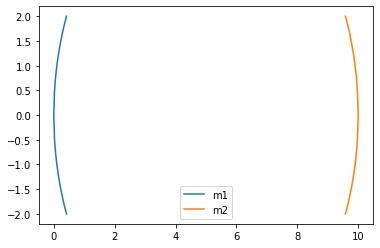

In [170]:
m1 = Mirror(RoC=5,r=2,z0=0)
m2 = Mirror(RoC=-5,r=2,z0=10,tilt=0.1)

plt.plot(*m1.surf(),label='m1')
plt.plot(*m2.surf(),label='m2')
plt.legend()

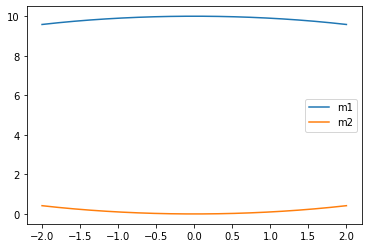

In [192]:
xpts = linspace(-r,r,20)
plt.plot(xpts, m1.sag(xpts),label='m1')
plt.plot(xpts, m2.sag(xpts),label='m2')
plt.legend()

guess 0: 1.0
0.9866914762704517 9.901677256884142
[ 0.98669148 -0.19728416]
guess 1: -0.9861501079229364


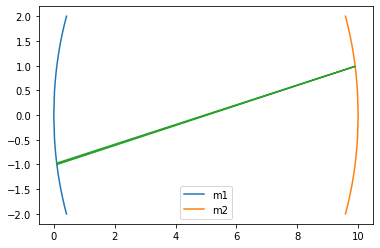

In [333]:
m1 = Mirror(RoC=5,r=2,z0=0)
m2 = Mirror(RoC=-5,r=2,z0=10)

plt.plot(*m1.surf(),label='m1')
plt.plot(*m2.surf(),label='m2')

# starting parameter for a ray
w1=-1
th1=.2
chi0 = array([w1,th1])

# 
def wz_next(ray, mirrors, guess):
    """
    w2, z2 where the ray will impinge on the next surface
    
    mirrors: a two-tuple of mirror objects that have the function sag(x). 
        the first (second) entry is the staring (ending) surface
    """
    w1,th1 = ray
    m1,m2 = mirrors
    f = lambda w2: (w2 - w1)/abs(m2.sag(w2) - m1.sag(w1)) - tan(th1)
    w2 = newton(f, guess)
    z2 = m2.sag(w2)
    return w2, z2

guess = chi0[0] + chi0[1]*L
print('guess 0:',guess)
w2,z2 = wz_next(chi0, (m1,m2), guess=guess)
print(w2,z2)
chi1 = array([w2,th1])

# reflect
chi2 = dot(m2.M(chi1),chi1)
print(chi2)
# print(chi1)
# print(chi2)

guess = chi2[0] + chi2[1]*L
print('guess 1:',guess)
w3,z3 = wz_next(chi2,(m2,m1), guess=guess)

# chi1 = dot(array([[1,d],[0,1]]),chi0)
rayx = [chi0[0], chi1[0], w3]
z1 = m1.sag(w1)
rayz = [z1,z2,z3]
plt.plot(rayz,rayx)
# plt.scatter([m2.sag(chi1[0])],[chi1[0]])
plt.legend()

In [320]:
chi0[0] + chi0[1]*L

1.0

In [307]:
print(rayx)
# starting w, w after trip 1, before refl, w after trip 2
w1, chi0[0] + 10*chi0[1], chi2[0] + 10*chi2[1]

[-1.0, 0.9866914762704506, -0.9733756749108328]


(-1, 1.0, -0.9861501079229331)

In [304]:
chi1[1]

0.2

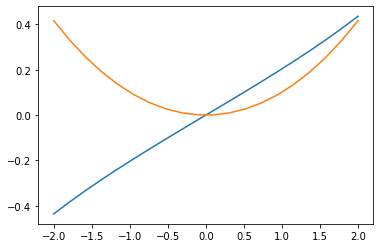

In [222]:
xpts = linspace(-r,r,20)
plt.plot(xpts, m1.slope(xpts))
plt.plot(xpts, m1.sag(xpts))

the ray left the cavity at trip 22


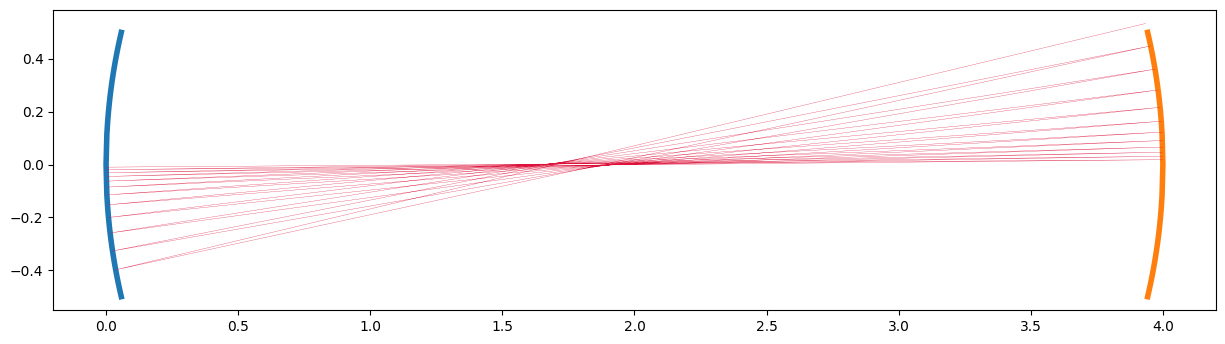

In [13]:
L = 4 # cavity length
alpha=0.55
m1 = Mirror(RoC=alpha*L,r=0.5,z0=0,tilt=0.9*2*pi)
m2 = Mirror(RoC=-alpha*L,r=0.5,z0=m1.z0+L,x0=0)
ML = Md(L) # propagation over distance L in free space

fig, ax = plt.subplots(figsize=(15,24))
ax.plot(*m1.surf(),label='m1',lw='4')
ax.plot(*m2.surf(),label='m2',lw='4')

def wz_next(ray, mirrors, guess):
    """
    w2, z2 where the ray will impinge on the next surface
    
    mirrors: a two-tuple of mirror objects that have the function sag(x). 
        the first (second) entry is the staring (ending) surface
    guess: a guess for w2, i.e. the ray height at surface 2
    """
    w1, th1 = ray
    m1,m2 = mirrors
    f = lambda w2: (w2 - w1)/abs(m2.sag(w2) - m1.sag(w1)) - tan(th1)
    w2 = newton(f, guess)
    z2 = m2.sag(w2)
    return w2, z2

trips = 100 # number of one-way trips in the cavity

# starting parameter for a marginal ray
lmbda = 7.8e-7
w0 = 5e-5
zR = pi*w0**2/lmbda
w1 = -w0*sqrt(1+((L/2)/zR)**2)
th1 = arctan2(sqrt(2)*w0,zR)
chi = array([w1,th1])
xpts = [w1]
zpts = [m1.sag(w1)]
w2_guess = dot(ML,chi)[0]
# print(f"initial ray. w={w1},th={th1}")

for i in range(trips):
    
    # propagate to next surface
    mirrors = (m2,m1) if i % 2 else (m1,m2)
#     print(f"guess {i}:",w2_guess)
    
    try:
        w2,z2 = wz_next(chi, mirrors, guess=w2_guess)
    except RuntimeError:
        break
        
#     print(w2,z2)
    xpts.append(w2) #xpts[i+1] = w2
    zpts.append(z2) #zpts[i+1] = z2
    
    # update waist after propagation
    chi = array([w2,chi[1]])
    
    # reflection
    chi = dot(mirrors[1].M(chi),chi)
#     print(f"after prop and refl. w={chi[0]},th={chi[1]}")
    
    w2_guess = dot(ML,chi)[0]
        
    if chi[0] > mirrors[1].r:
        print(f"the ray left the cavity at trip {i}")
        break
    
ax.plot(zpts,xpts,color='crimson',lw=0.2)
ax.set_aspect('equal')

In [341]:
lmbda = 7.8e-7
w0 = 5e-6
zR = pi*w0**2/lmbda
arctan2(sqrt(2)*w0,zR)

0.07010957526420673